## Use case 2: Distribution of certificates across repository types (Python)

> This notebook is based on the examples written in `R` from Dorothea Strecker's [examples-r/02_re3data_API_certification_by_type.ipynb](https://github.com/re3data/using_the_re3data_API/blob/main/examples-r/02_re3data_API_certification_by_type.ipynb).  
> Adapted in `Python` by Heinz-Alexander Fütterer.

Observants of the repository landscape are interested in conducting a multivariate analysis of certification status and type of research data repositories.

Research data repositories are diverse. The re3data Metadata Schema tries to account for that, resulting in rich and detailed metadata that can be accessed via the re3data API.

### Step 1: load packages

The package `httpx` includes the HTTP method GET, which will be used to request data from the re3data API. Responses from the redata API are returned in XML. `lxml` includes functions for working with XML, for example parsing or extracting content of specific elements. The `pandas` library is used for storing the responses in a tabular data structure (i.e. a `DataFrame`). It offers useful functions for data manipulation and reshaping as well. `seaborn` is a package for beautiful data visualization.

If necessary, install the packages before loading them.

In [1]:
# !pip install httpx==0.23.0 lxml==4.8.0 pandas==1.4.2 seaborn==0.11.2

In [2]:
import datetime
import typing

import httpx
import pandas
import seaborn
from lxml import html

seaborn.set_style("whitegrid")

### Step 2: obtain re3data IDs of all repositories indexed in re3data

Information on individual repositories can be extracted using the re3data ID. Therefore, re3data IDs of all repositories indexed in re3data need to be identified first, using the endpoint **/api/v1/repositories**. Details of the re3data APIs are outlined in the [re3data API documentaion](https://www.re3data.org/api/doc).

The endpoint is queried using `httpx.get()`. The XML response is parsed using `html.fromstring()`. XML elements or attributes can be identified using XPath syntax. All elements matching the XPath syntax for finding re3data urls are extracted with `.xpath()`. The three functions are nested in the example below.

The endpoint **/api/beta/repository** provides detailed information about individual repositories that can be accessed via re3data IDs. Therefore, URLs for the next query are collected.

In [3]:
URL = "https://www.re3data.org/api/beta/repositories"

re3data_response = httpx.get(URL, timeout=60)
tree = html.fromstring(re3data_response.content)
urls = tree.xpath("//@href")
print(len(urls))

urls[:5]

2872


['https://www.re3data.org/api/beta/repository/r3d100010141',
 'https://www.re3data.org/api/beta/repository/r3d100010148',
 'https://www.re3data.org/api/beta/repository/r3d100010153',
 'https://www.re3data.org/api/beta/repository/r3d100010201',
 'https://www.re3data.org/api/beta/repository/r3d100010209']

### Step 3: define what information about the repositories should be requested

The function `extract_repository_info()` defined in the following code block points to and extracts the content of specific XML elements and attributes. This function will be used later to extract the spedified information from responses of the re3data API. Its basic structure is similar to the process of extracting the URLs outlined in step 2 above.  
The XPath expressions defined here will extract the re3data IDs, certificates, and types of the repositories. According to version 2.2 of the [re3data Metadata Schema](https://doi.org/10.2312/re3.006) used by the API, **type** and **certificate** have an occurence of 1-n and 0-n, respectively. This means that the elements can occur multiple times. For this reason, all occurrences of these elements are stored in a list. These lists can be separated for the analysis later. In this and similar cases, extracting the re3data ID is particularly important, as it can serve as an ID column in the analysis. Results are stored in a dictionary.

Depending on specific use cases, this function can be adapted to extract a different set of elements and attributes. For an overview of the metadata re3data offers, please refer to the documentation of the [re3data Metadata Schema](https://doi.org/10.2312/re3.006).

In [4]:
def extract_repository_info(
    repository_metadata_xml: html.HtmlElement,
) -> typing.Dict[str, typing.Any]:
    """Extracts wanted metadata elements from a given repository metadata xml representation.

    Args:
        repository_metadata_xml: XML representation of repository metadata.

    Returns:
        Dictionary representation of repository metadata.

    """

    namespaces = {"r3d": "http://www.re3data.org/schema/2-2"}
    return {
        "re3data_id": repository_metadata_xml.xpath("//re3data.orgidentifier/text()", namespaces=namespaces)[0],
        "type": repository_metadata_xml.xpath("//type/text()", namespaces=namespaces),
        "certificate": repository_metadata_xml.xpath("//certificate/text()", namespaces=namespaces),
    }

### Step 4: gather detailed information about repositories

After preparing the list of URLs and the extracting function, these components can be put together. The code block below iterates through the list of URLs using a for-loop. For each repository, data is requested from the re3data API using `.get()` from a `httpx.Client`. The XML response is parsed with `html.fromstring()` before `extract_repository_info()` is called. The results are then appended to `results_list`.

Because these steps are repeated for all repositories indexed in re3data, the process will take a while (~ 5 minutes).

`repository_info` is a container for storing results of the API query. The DataFrame has four columns corresponding to names of the list items defined by `extract_repository_info()`.

In [5]:
results = []

with httpx.Client() as client:
    for i, url in enumerate(urls):
        # Uncomment to see progress, every 100th url is printed
        # if i % 100 == 0:
        #     print(url)

        repository_metadata_response = client.get(url, follow_redirects=True)
        repository_metadata_xml = html.fromstring(repository_metadata_response.content)
        results.append(extract_repository_info(repository_metadata_xml))

repository_info = pandas.DataFrame(results)
repository_info.head()

,re3data_id,type,certificate
0,r3d100010141,"[disciplinary, institutional]",[]
1,r3d100010148,"[disciplinary, institutional]",[]
2,r3d100010153,[disciplinary],[]
3,r3d100010201,"[disciplinary, institutional]",[RatSWD]
4,r3d100010209,[disciplinary],[]


### Step 5: process the results

The first line in the code block below uses the method `.astype(bool)` on the column **certificate**, resulting in a new column indicating whether a repository received at least one certificate (`True`) or not (`False`).

The results can be stored locally with `.to_csv()`. Columns containing values in lists (e.g. **type**) in the column type are separated with `.explode()`, creating new rows if a repository was assigned multiple values. The resulting dataframe follows the specifications of [tidy data](http://dx.doi.org/10.18637/jss.v059.i10), a "standard way of mapping the meaning of a dataset to its structure". Tidy dataframes are often easier to understand and work with.

Although this introduces duplication - multiple rows can now correspond to the same repository - the re3data IDs can be used to deduplicate results at any time.

In [6]:
repository_info["certification_status"] = repository_info["certificate"].astype(bool)
repository_info.drop("certificate", axis=1, inplace=True)

repository_info = repository_info.explode("type")
repository_info["type"] = repository_info["type"].astype("category")

repository_info.drop_duplicates(inplace=True)
repository_info.sort_values(by="re3data_id", inplace=True)
repository_info.head(10)

,re3data_id,type,certification_status
688,r3d100000001,disciplinary,True
1207,r3d100000002,disciplinary,False
1383,r3d100000004,disciplinary,True
2703,r3d100000005,institutional,False
2191,r3d100000006,disciplinary,True
639,r3d100000007,institutional,False
639,r3d100000007,disciplinary,False
1590,r3d100000011,disciplinary,True
1015,r3d100000012,disciplinary,True
2336,r3d100000013,other,False


### Step 6: visualize the results

Now that the results are processed, they can be visualized. The example below generates a `seaborn.catplot` showing the prevalence of (any) certification by repository type.  
Please note that, as mentioned above, **type** has an occurence of 1-n. Some repositories are assigned more than one type, for example *institutional* and *other*.

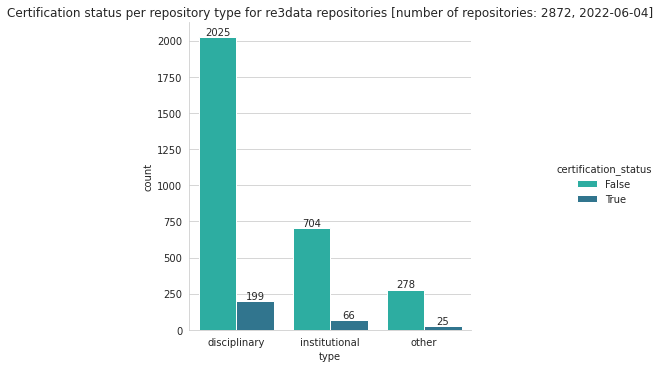

In [7]:
# color scheme for the plot
colors = ["#17C3B2", "#227C9D"]

# generate plot
grid = seaborn.catplot(x="type", hue="certification_status", data=repository_info, kind="count", palette=colors)

# annotate counts for each bar
for ax in grid.axes.flat:
    for container in ax.containers:
        ax.bar_label(container)

today = datetime.date.today()
num_repositories = len(repository_info["re3data_id"].unique())

# add title
grid.set(
    title=f"Certification status per repository type for re3data repositories [number of repositories: {num_repositories}, {today}]"
);